In [1]:
#!/usr/bin/python3
# -*- coding:utf-8 -*-
# @Author: XinWang
# @Time:2019/7/26 17:37
# @FileName: UseNet.py
# @Software: PyCharm
from models import *
from loadNetParams import *
import os
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import random
from mxnet.gluon import data as gdata

In [2]:
def load_all_data():
    root = 'data/raw_exp'
    file_list = os.listdir(root)
    file_labels = dict(zip(file_list, list(range(1,len(file_list)+1))))
    samples_list = []

    for file in file_list:
        with open(os.path.join(root,file), 'r') as f:
            first_row = f.readline()
            first_row = first_row.strip().split('\t')
            for sample in first_row[1:]:
                if int(sample.strip()[-3:-2]) == 0:
                    # case
                    samples_list.append((sample, file_labels[file]))
                else:
                    # control
                    samples_list.append((sample, 0))
    sample2labels = pd.DataFrame(samples_list,columns=['sampleID', 'label'])
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_sample(np.array(sample2labels['sampleID']).reshape(-1, 1), 
                                              np.array(sample2labels['label'])
                                             ) # 过采样
    allsamples = pd.DataFrame({'sampleID':X_resampled[:,0], 'label':y_resampled})
    length = allsamples.shape[0]
    index_list = list(range(length))
    train_num, validation_num, test_num= 0.7, 0.2, 0.1
    random.shuffle(index_list)
    train_index = index_list[0:int(length*train_num)]
    validation_index = index_list[int(length*train_num): int(length*train_num) + int(length*validation_num)]
    test_index = index_list[int(length * train_num) + int(length * validation_num):]

    train_samples = allsamples.loc[train_index]
    validation_samples = allsamples.loc[validation_index]
    test_samples = allsamples.loc[test_index]
    
    return train_samples, validation_samples, test_samples

In [3]:
dataset = LoadData()
net2, feature2 = train_model(dataset)

E:\wx\2019上课题\程序\GCN\gcn\loadNetParams.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.res['entryID'] = self.res[1].map(geneset2entryID).apply(lambda x: 'entry' + str(x))


loading ppi net data...
loading relation between protein and entry ...
loading entry net...
loading relation between entry and pathway...
loading pathway net...
build net models...


In [5]:
net2.load_parameters('data/net_params')

In [4]:
batch_size = 10
exp = pd.read_csv('data/exp_data.csv')

In [6]:
train_samples, validation_samples, test_samples = load_all_data()
test_x = nd.array(exp[test_samples['sampleID']]).transpose()
test_y = nd.array(test_samples['label'])

In [7]:
dataset = gdata.ArrayDataset(test_x, test_y)
data_iter = gdata.DataLoader(dataset, batch_size, shuffle=True)

In [8]:
def evaluate_accuracy(data_iter, net):
    acc, n = 0.0, 0
    for X, Y in data_iter:
        pre = net(X.reshape(*X.shape, 1))
        acc += (pre.argmax(axis=1)==Y).sum().asscalar()
        n += len(Y)
        if n%500 == 0:
            print(f"acc: {acc}, {n}, {acc / n}")
    return acc / n

In [9]:
evaluate_accuracy(data_iter, net2)

acc: 324.0, 500, 0.648
acc: 658.0, 1000, 0.658
acc: 995.0, 1500, 0.6633333333333333
acc: 1316.0, 2000, 0.658
acc: 1634.0, 2500, 0.6536
acc: 1958.0, 3000, 0.6526666666666666
acc: 2271.0, 3500, 0.6488571428571429


0.6476399560922064

In [35]:
res = net2(x.reshape(*x.shape, 1))

In [36]:
res.argmax(axis=1)


[ 3. 17.  7.  3.  3.  4. 23.  3. 10. 27.]
<NDArray 10 @cpu(0)>

In [37]:
y


[ 2. 16. 25.  3.  4.  4.  6. 16.  8. 27.]
<NDArray 10 @cpu(0)>

In [34]:
for x, y in data_iter:
    break

In [44]:
output_layers = {1: 'GGI', 2: 'PPI2entry', 4: 'EEI', 5: 'entry2pathway', 7: 'PPI', 9: 'Dense0', 10: 'Dense1'}

In [47]:
output_inner = x.reshape(*x.shape, 1)
output_res = {}

for i,layers in enumerate(net2):
    output_inner =  layers(output_inner)
    if i in output_layers.keys():
        output_res[output_layers[i]] = output_inner

In [59]:
output_res['GGI'][1,::].asnumpy()

array([[-0.6382885 , -0.76583934,  0.28703734, ...,  1.6032488 ,
        -0.76583934, -0.6223338 ],
       [-0.97459716, -1.1835563 ,  0.5413104 , ...,  2.6975834 ,
        -1.1835563 , -0.9484595 ],
       [-0.5605946 , -0.6995177 ,  0.44723177, ...,  1.8807944 ,
        -0.6995177 , -0.5432175 ],
       ...,
       [-0.67095995, -0.82738227,  0.4638161 , ...,  2.0779562 ,
        -0.82738227, -0.6513939 ],
       [-0.3144164 , -0.41528386,  0.41733295, ...,  1.4581954 ,
        -0.41528386, -0.30179948],
       [-0.6242033 , -0.77909964,  0.49950153, ...,  2.0978932 ,
        -0.77909964, -0.6048282 ]], dtype=float32)

In [48]:
output_inner.argmax(axis=1)


[ 3. 17.  7.  3.  3.  4. 23.  3. 10. 27.]
<NDArray 10 @cpu(0)>

In [52]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
def tsne(data, label=None):
    X_tsne = TSNE(learning_rate=100).fit_transform(data)
    if label is None:
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
    else:
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=label, cmap='hsv')

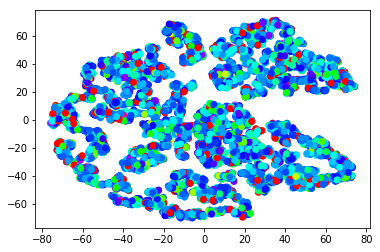

In [119]:
data = output_res['GGI'][3,:,:].asnumpy()
tsne(data,x[3,:].asnumpy())

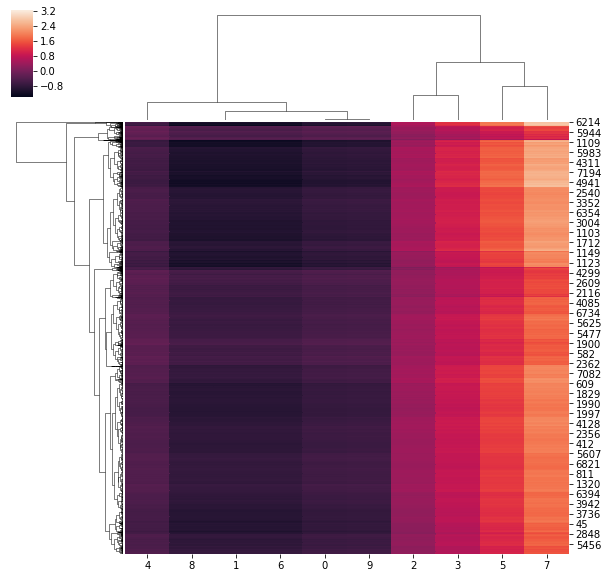

In [118]:
sns.clustermap(data)